# Reading Phantom HDF5 dumps

Here we demonstrate reading in a collection of Phantom HDF5 dump files, on which we will perform visualization and analysis.

In [1]:
from plonk.plonk.dump import Dump

Read the dump files into a list. Each element of the list is a Plonk Dump object.

In [2]:
dump_file_names = ['data/disc_00000.h5']

dumps = list()

for dump_file_name in dump_file_names:
    print(f'Reading {dump_file_name}...')
    dump = Dump(dump_file_name)
    dumps.append(dump)

Reading data/disc_00000.h5...


We can access the dump parameters, i.e. the Phantom header. This is a dictionary with keys given by the Phantom header. For example we can access `hfact`, `alpha`, etc.

In [3]:
hfact = dumps[0].parameters["hfact"]
alpha = dumps[0].parameters["alpha"]

print(f'hfact = {hfact:.1f}')
print(f'alpha = {alpha:.3f}')

hfact = 1.0
alpha = 0.236


There is also a dictionary for units where the value is the value of the code units in cgs units.

In [4]:
for key in dumps[0].units:
    print(f'{key:20} {dumps[0].units[key]}')

distance             14960000000000.0
mass                 1.9891e+33
time                 5022728.790082334
frequency            1.9909496247827625e-07
velocity             2978460.6386750126
momentum             5.924456056388467e+39
force                1.1795293562508584e+33
pressure             5270424.14464802
energy               1.1795293562508584e+33
density              5.94103125029151e-07
surface_density      8887782.7504361
angular_momentum     8.862986260357147e+52
torque               1.7645759169512842e+46


The particle data is stored as a Pandas dataframe. Every particle has an `itype`, positions (as `x`, `y`, `z`), mass, smoothing length, and density (computed from the smoothing length), as well as any other quantities stored in the dump file, such as velocity (as `vx`, `vy`, `vz`), dust fraction, and so on. For example, the following shows the first 5 particles of the first dump file.

In [5]:
dumps[0].particles.iloc[:5]

,itype,x,y,z,h,m,rho,pressure,vx,vy,vz,dustfrac,divv,dt
0,1,-31.269099,-35.027568,-11.247553,1.629258,1.000000e-07,2.312227e-08,8.319090e-12,0.106367,-0.095378,0.0,0.002055,0.001085,9.017928
1,1,18.982811,130.934768,23.591143,2.426354,1.000000e-07,7.000633e-09,1.509708e-12,-0.082555,0.011762,0.0,0.001227,0.000152,18.035856
2,1,109.807836,-48.332495,3.099149,2.261923,1.000000e-07,8.641047e-09,1.971924e-12,0.035373,0.080244,0.0,0.010808,-0.000184,18.035856
3,1,-87.225447,-35.186138,-4.220097,1.752120,1.000000e-07,1.859126e-08,4.790044e-12,0.037253,-0.092721,0.0,0.006507,-0.000011,18.035856
4,1,-83.974547,4.328364,4.179969,1.609641,1.000000e-07,2.397799e-08,6.533154e-12,-0.005529,-0.105704,0.0,0.014254,-0.000158,18.035856


Similarly we have access to the sink particle data stored as a Pandas dataframe.

In [6]:
dumps[0].sinks

,x,y,z,m,h,hsoft,macc,spinx,spiny,spinz,tlast,vx,vy,vz
0,-3.827373e-15,-4.042294e-14,-8.654111e-15,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.529900e-17,-8.085516e-17,0.0


# Analyzing Phantom data

We can perform analysis on Phantom data. Currently available is a function `disc_analysis` which is equivalent to the Phantom analysis module in `analysis_disc.f90`.

In [7]:
from plonk.plonk.analysis.disc import disc_analysis

This analysis assumes a single disc around a single star (represented as a sink particle). We need to define the number of radial bins to average our data, as well as the inner and outer disc radius.

In [8]:
number_radial_bins = 200
radius_in          = 1
radius_out         = 150

The analysis produces a list of Pandas dataframes `radial_averages`. Each datafram has index associated with the radial bin.

In [9]:
radial_averages = list()
particles       = list()
sinks           = list()

for dump in dumps:

    print('\nPerforming disc analysis...\n')
    radial_averages_ = disc_analysis( radius_in          = radius_in,
                                      radius_out         = radius_out,
                                      number_radial_bins = number_radial_bins,
                                      dump               = dump )

    radial_averages.append(radial_averages_)


Performing disc analysis...

Calculating extra quantities on the particles and sinks...
And adding them to the DataFrame

Assuming the first sink particle is the central star


Now we can use the data in radial_averages to plot radially averaged quantities such as the surface density profile, or the disc aspect ratio, for example.

Text(0, 0.5, 'scale height')

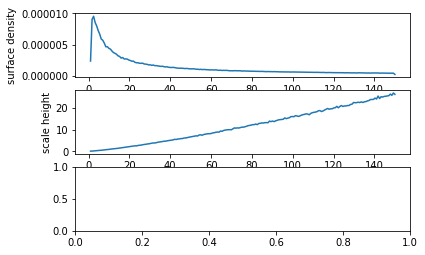

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3)

for df in radial_averages:
    ax[0].plot(df['R'], df['sigma'])
ax[0].set_xlabel('radius')
ax[0].set_ylabel('surface density')

for df in radial_averages:
    ax[1].plot(df['R'], df['H'])
ax[1].set_xlabel('radius')
ax[1].set_ylabel('scale height')

# Visualizing Phantom data

We can use highly-optimized Splash interpolation routines to visualize Phantom data.

In [11]:
from plonk.plonk.visualization.image import Image

We create a list of Image objects. One for each dump file.

In [12]:
images = list()
for dump in dumps:
    images.append(Image(dump))

Then we plot, for example, the columns density:

Rendering rho


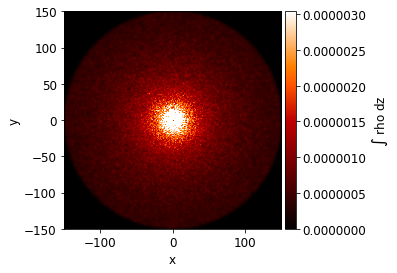

In [13]:
images[0].plot(render='rho', render_fraction_max=0.05)

We can overlay vector fields:

Rendering rho
Vector field v


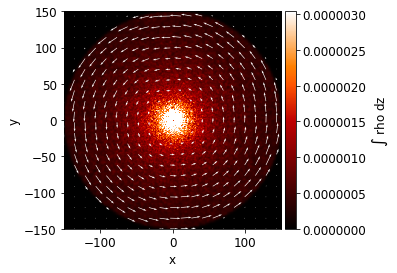

In [14]:
images[0].plot(render='rho', vector='v', render_fraction_max=0.05)

We can rotate about an arbitrary axis:

Rotating 60 deg around [0.71, 0.71, 0.00]
Rendering rho


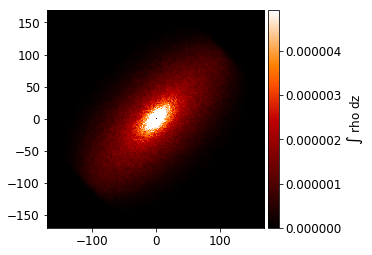

In [15]:
images[0].plot(render='rho', rotation_angle=np.pi/3, rotation_axis=[1, 1, 0],
               render_fraction_max=0.05)

We can take a cross-section:

Rotating 90 deg around [1.00, 0.00, 0.00]
Rendering rho


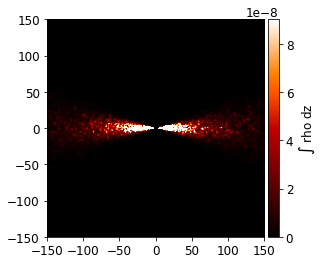

In [16]:
images[0].plot(render='rho', rotation_angle=np.pi/2, rotation_axis=[1, 0, 0],
               cross_section=True, render_fraction_max=0.01)

We can plot the particles. (This is somewhat slow.)

Plotting particles


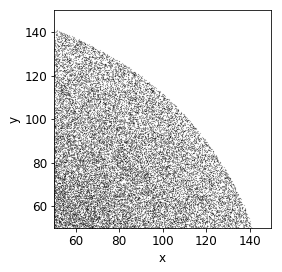

In [17]:
images[0].plot(horizontal_range=[50, 150], vertical_range=[50, 150])